# Import Libraries

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

#model training
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB, ComplementNB
from sklearn.metrics import log_loss, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, auc, roc_curve,RocCurveDisplay
from imblearn.over_sampling import SMOTE
from collections import Counter

#dict
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from pprint import pprint
from gensim.models import Word2Vec
import gensim.downloader
from scipy.spatial.distance import cosine

#visualization
!pip install pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

#warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load Dataset

In [ ]:
PATH = 'https://raw.githubusercontent.com/ProfAI/natural-language-processing/refs/heads/main/datasets/Verifica%20Finale%20-%20Spam%20Detection/'

dataset = pd.read_csv(PATH + 'spam_dataset.csv',index_col= 0)
dataset.head()

,label,text,label_num
605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
4685,spam,"Subject: photoshop , windows , office . cheap ...",1
2030,ham,Subject: re : indian springs\nthis deal is to ...,0


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5171 entries, 605 to 4807
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      5171 non-null   object
 1   text       5171 non-null   object
 2   label_num  5171 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 161.6+ KB


In [ ]:
print(f'Numbers of duplicated emails: {dataset.text.duplicated().sum()}')

Numbers of duplicated emails: 178


In [ ]:
dataset[dataset.text.duplicated()]
dataset.drop_duplicates(subset='text',inplace=True)
print(f'Current duplicate emails: {dataset.text.duplicated().sum()}')

Current duplicate emails: 0


In [ ]:
#drop columns useless
dataset.drop(['label_num'],axis=1, inplace=True)
dataset

,label,text
605,ham,Subject: enron methanol ; meter # : 988291\nth...
2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a..."
3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou..."
4685,spam,"Subject: photoshop , windows , office . cheap ..."
2030,ham,Subject: re : indian springs\nthis deal is to ...
...,...,...
2849,ham,"Subject: fw : crosstex energy , driscoll ranch..."
1518,ham,Subject: put the 10 on the ft\nthe transport v...
404,ham,Subject: 3 / 4 / 2000 and following noms\nhpl ...
1409,ham,Subject: industrial worksheets for august 2000...


# Exploration Data Analysis

In [ ]:
label_count= dataset.label.value_counts()
label_count

total = len(dataset)

ham_percentage = (label_count[0] / total) * 100
spam_percentage = (label_count[1] / total) * 100

print(f'Distribution of {label_count}: \n')
print(f'ham_percentage: {ham_percentage:.2f}%')
print(f'spam_percentage: {spam_percentage:.2f}%')

Distribution of label
ham     3531
spam    1462
Name: count, dtype: int64: 

ham_percentage: 70.72%
spam_percentage: 29.28%


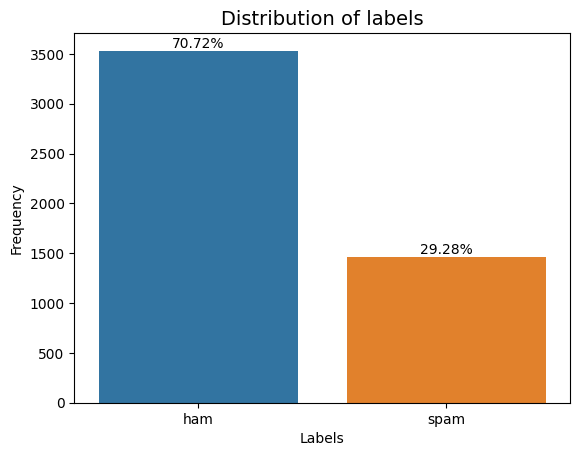

In [ ]:
_ = sns.countplot(data=dataset,x='label',hue='label')
plt.title('Distribution of labels', fontsize = 14)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.annotate(f'{ham_percentage:.2f}%',xy=(0, label_count[0]), ha='center', va='bottom')
plt.annotate(f'{spam_percentage:.2f}%',xy=(1, label_count[1]), ha='center', va='bottom')
plt.show()

The dataset is **unbalanced**

Ham email = 70.72%

Spam = 29.28%

In [ ]:
# transforming the target variable into binary
le = LabelEncoder()
dataset.label = le.fit_transform(dataset.label)
dataset.head()

,label,text
605,0,Subject: enron methanol ; meter # : 988291\nth...
2349,0,"Subject: hpl nom for january 9 , 2001\n( see a..."
3624,0,"Subject: neon retreat\nho ho ho , we ' re arou..."
4685,1,"Subject: photoshop , windows , office . cheap ..."
2030,0,Subject: re : indian springs\nthis deal is to ...


In [ ]:
# Download NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from nltk.corpus import stopwords
def clean_text(text):
  """

  This function is used for cleaning column text

  """

    # Remove punctuation and number
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # all text in lowercase
    words = word_tokenize(text.lower())

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Lemmatization (base form)
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Reconstructs clean text
    return ' '.join(words)

In [ ]:
# trying a few examples
example_text = dataset.text[605]
example_text1 = dataset.text[2349]
example_text2 = dataset.text[3624]

text_cleaned = clean_text(example_text)
text1_cleaned = clean_text(example_text1)
text2_cleaned = clean_text(example_text2)
print(text_cleaned,'\n')
print(text1_cleaned,'\n')
print(text2_cleaned)

subject enron methanol meter follow note gave monday preliminary flow data provided daren please override pop daily volume presently zero reflect daily activity obtain gas control change needed asap economics purpose 

subject hpl nom january see attached file hplnol xl hplnol xl 

subject neon retreat ho ho ho around wonderful time year neon leader retreat time know time year extremely hectic tough think anything past holiday life go past week december january like think minute calender handed beginning fall semester retreat scheduled weekend january youth minister conference brad dustin connected week going change date following weekend january come part need think think agree important u get together time recharge battery get far spring semester lot trouble difficult u get away without kid etc brad came potential alternative get together weekend let know prefer first option would retreat similar done past several year year could go heartland country inn www com outside brenham nice 

In [ ]:
#text cleaning
dataset.text = dataset.text.apply(clean_text)
dataset.head()

,label,text
605,0,subject enron methanol meter follow note gave ...
2349,0,subject hpl nom january see attached file hpln...
3624,0,subject neon retreat ho ho ho around wonderful...
4685,1,subject photoshop window office cheap main tre...
2030,0,subject indian spring deal book teco pvr reven...


# Train Test Split

In [ ]:
X = dataset.text
y = dataset.label

print(f'Shape X: {X.shape}\nShape y:{y.shape}')

Shape X: (4993,)
Shape y:(4993,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify= y)

print(f'Train Set Shape: {X_train.shape, y_train.shape}')
print(f'Test Set Shape:{X_test.shape, y_test.shape}')

Train Set Shape: ((3994,), (3994,))
Test Set Shape:((999,), (999,))


In [ ]:
tfidf = TfidfVectorizer(stop_words= 'english')
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

# Logistic Regression

In [ ]:
#Logistic regression
lr = LogisticRegression(class_weight='balanced',random_state=42)
lr.fit(X_train,y_train)

y_hat_train = lr.predict(X_train)
y_hat_train_proba = lr.predict_proba(X_train)

y_hat_test = lr.predict(X_test)
y_hat_test_proba = lr.predict_proba(X_test)

print(f'Train:\n {classification_report(y_train,y_hat_train)}')
print(f'*'*50)
print(f'Test:\n {classification_report(y_test,y_hat_test)}')
print(f'*'*50)
print('Train ROC-AUC:', (roc_auc_score(y_train, y_hat_train_proba[:, 1])))
print('Test ROC-AUC:', roc_auc_score(y_test, y_hat_test_proba[:, 1]))
print(f'*'*50)
print(f'Confusion Matrix: \n {confusion_matrix(y_test,y_hat_test)}')

Train:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98      2825
           1       0.93      1.00      0.96      1169

    accuracy                           0.98      3994
   macro avg       0.96      0.98      0.97      3994
weighted avg       0.98      0.98      0.98      3994

**************************************************
Test:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96       706
           1       0.85      1.00      0.92       293

    accuracy                           0.95       999
   macro avg       0.93      0.96      0.94       999
weighted avg       0.96      0.95      0.95       999

**************************************************
Train ROC-AUC: 0.9998071114408352
Test ROC-AUC: 0.997379845111139
**************************************************
Confusion Matrix: 
 [[656  50]
 [  0 293]]


# ROC-AUC Curve Train and Test Set

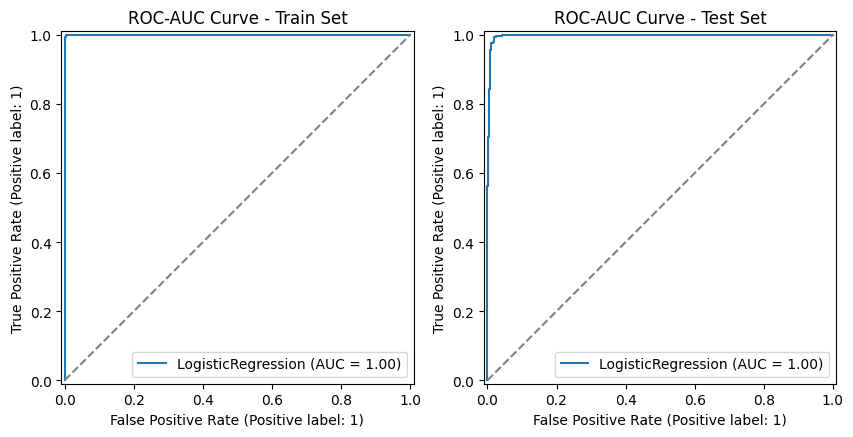

In [ ]:
#display roc-auc curve train
fig, ax = plt.subplots(1,2, figsize=(10,6))

RocCurveDisplay.from_estimator(lr,X_train,y_train, ax=ax[0])
ax[0].set_title('ROC-AUC Curve - Train Set')
ax[0].plot([0, 1], [0, 1], linestyle='--', color='gray')

#display roc curve test
RocCurveDisplay.from_estimator(lr,X_test,y_test, ax=ax[1])
ax[1].set_title('ROC-AUC Curve - Test Set')
ax[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.show()

The ROC curve is a visual representation of model performance across all thresholds.
The area under the ROC curve (AUC) represents the probability that the model, if given a randomly chosen positive and negative example, will rank the positive higher than the negative.

The Logistic Regression model scored 99.7% in test set. It means that the model is very accurate to detect **spam emails**

# Naive Bayes Models

In [ ]:
#Bernoulli NB
benb = BernoulliNB()
benb.fit(X_train,y_train)
report = classification_report(y_test, benb.predict(X_test))
print(f'Test Set \n {report}')

confusion_matrix(y_test, benb.predict(X_test))

Test Set 
               precision    recall  f1-score   support

           0       0.82      0.98      0.89       706
           1       0.92      0.48      0.63       293

    accuracy                           0.83       999
   macro avg       0.87      0.73      0.76       999
weighted avg       0.85      0.83      0.82       999



array([[694,  12],
       [153, 140]])

In [ ]:
#Multinomial NB
munb = MultinomialNB()
munb.fit(X_train,y_train)
report = classification_report(y_test, munb.predict(X_test))
print(f'Test Set \n {report}')

confusion_matrix(y_test, munb.predict(X_test))

Test Set 
               precision    recall  f1-score   support

           0       0.92      0.99      0.96       706
           1       0.98      0.80      0.88       293

    accuracy                           0.94       999
   macro avg       0.95      0.89      0.92       999
weighted avg       0.94      0.94      0.93       999



array([[702,   4],
       [ 60, 233]])

In [ ]:
#Complement NB
comnb = ComplementNB()
comnb.fit(X_train,y_train)
report = classification_report(y_test, comnb.predict(X_test))
print(f'Test Set \n {report}')

confusion_matrix(y_test, comnb.predict(X_test))

Test Set 
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       706
           1       0.98      0.94      0.96       293

    accuracy                           0.98       999
   macro avg       0.98      0.97      0.97       999
weighted avg       0.98      0.98      0.98       999



array([[699,   7],
       [ 17, 276]])

In [ ]:
#Gaussian NB
gausnb = GaussianNB()
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()
gausnb.fit(X_train_dense,y_train)
report = classification_report(y_test, gausnb.predict(X_test_dense))
print(f'Test Set \n {report}')

confusion_matrix(y_test, gausnb.predict(X_test_dense))

Test Set 
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       706
           1       0.89      0.89      0.89       293

    accuracy                           0.94       999
   macro avg       0.93      0.93      0.93       999
weighted avg       0.94      0.94      0.94       999



array([[675,  31],
       [ 31, 262]])

Naive Bayes is used for creating classifier models, which allocate class labels to define problem instances, represented as vectors of feature values, where the class labels are taken from some finite set. Naive Bayes classifiers assume that the value of a particular feature is independent of the given value of any other feature in the given class. Parameter estimation for Naive Bayes models applies maximum likelihood in many practical applications, or the Naive Bayes model can be implemented without applying Bayesian probability or any type of Bayesian procedure.

The results obtained are very good, even considering the unbalanced dataset.
At present, the best performing models are the logistic regression (LR) and the Complement Naive bayes (CNB).

# Logistic Regression with SMOTE

In [ ]:
#Smote model
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train,y_train)

print(f'Resampled dataset shape %s' % Counter(y_train_res))

Resampled dataset shape Counter({0: 2825, 1: 2825})


In [ ]:
#Logistic regression with smote
lr = LogisticRegression(class_weight='balanced',random_state=42)
lr.fit(X_train_res,y_train_res)

y_hat_train = lr.predict(X_train_res)
y_hat_train_proba = lr.predict_proba(X_train_res)

y_hat_test = lr.predict(X_test)
y_hat_test_proba = lr.predict_proba(X_test)

print(f'Train Report \n {classification_report(y_train_res,y_hat_train)}')
print(f'*'*50)
print(f'Test Report \n {classification_report(y_test,y_hat_test)}')
print(f'*'*50)
print('Train ROC-AUC:', (roc_auc_score(y_train_res, y_hat_train_proba[:, 1])))
print('Test ROC-AUC:', roc_auc_score(y_test, y_hat_test_proba[:, 1]))
print(f'*'*50)
print(f'Confusion Matrix: \n {confusion_matrix(y_test,y_hat_test)}')

Train Report 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      2825
           1       0.98      1.00      0.99      2825

    accuracy                           0.99      5650
   macro avg       0.99      0.99      0.99      5650
weighted avg       0.99      0.99      0.99      5650

**************************************************
Test Report 
               precision    recall  f1-score   support

           0       1.00      0.95      0.98       706
           1       0.90      1.00      0.95       293

    accuracy                           0.97       999
   macro avg       0.95      0.98      0.96       999
weighted avg       0.97      0.97      0.97       999

**************************************************
Train ROC-AUC: 0.9998803351867804
Test ROC-AUC: 0.9974426901545989
**************************************************
Confusion Matrix: 
 [[673  33]
 [  0 293]]


# Naive Bayes Models with SMOTE

In [ ]:
#Bernoulli NB
benb = BernoulliNB()
benb.fit(X_train_res,y_train_res)
report = classification_report(y_test, benb.predict(X_test))
print(f'Test Set \n {report}')

print(f'Confusion Matrix: \n {confusion_matrix(y_test, benb.predict(X_test))}')

Test Set 
               precision    recall  f1-score   support

           0       0.81      0.98      0.88       706
           1       0.88      0.44      0.59       293

    accuracy                           0.82       999
   macro avg       0.85      0.71      0.74       999
weighted avg       0.83      0.82      0.80       999

Confusion Matrix: 
 [[689  17]
 [164 129]]


In [ ]:
#Multinomial NB
munb = MultinomialNB()
munb.fit(X_train_res,y_train_res)
report = classification_report(y_test, munb.predict(X_test))
print(f'Test Set \n {report}')

print(f'Confusion Matrix: \n {confusion_matrix(y_test, munb.predict(X_test))}')

Test Set 
               precision    recall  f1-score   support

           0       1.00      0.95      0.97       706
           1       0.89      0.99      0.94       293

    accuracy                           0.96       999
   macro avg       0.94      0.97      0.96       999
weighted avg       0.97      0.96      0.96       999

Confusion Matrix: 
 [[670  36]
 [  2 291]]


In [ ]:
#Complement NB
comnb = ComplementNB()
comnb.fit(X_train_res,y_train_res)
report = classification_report(y_test, comnb.predict(X_test))
print(f'Test Set \n {report}')

confusion_matrix(y_test, comnb.predict(X_test))

Test Set 
               precision    recall  f1-score   support

           0       1.00      0.95      0.97       706
           1       0.89      0.99      0.94       293

    accuracy                           0.96       999
   macro avg       0.94      0.97      0.96       999
weighted avg       0.97      0.96      0.96       999



array([[670,  36],
       [  2, 291]])

After the application of Smote, then the creation of minority class data, Logistic Regression performs very well.

* True Positive:  673  
* False Negative: 33
* False Positive: 0
* True Negative:  293

The model is excellent in recognising Spam e-mails, the accuracy is highest, which means that the model is extremely effective in not misclassifying Ham e-mails as Spam.

The only area for improvement is recall, which is not perfect due to the 33 false negatives (Spam wrongly classified as Ham), but still a very good value.

The complement Naive bayes model make the statistics worse as it works well even with unbalanced data.

# Inference Logistic Regression and Complement Naive bays

In [ ]:
def is_spam(text):
  text_tfidf = tfidf.transform([text])
  pred = lr.predict(text_tfidf)[0]
  return pred == 1

In [ ]:
def is_spam_nb(text):
  text_tfidf = tfidf.transform([text])
  pred = comnb.predict(text_tfidf)[0]
  return pred == 1

In [ ]:
print(is_spam('Congratulations! You have won a FREE gift!'))
print(is_spam('Earn $10,000 per month effortlessly!'))
print(is_spam('Dear, Matteo i have a question for you'))
print(is_spam('Here is your GitHub launch code!'))

True
True
False
True


In [ ]:
print(is_spam_nb('Earn $10,000 per month effortlessly!'))
print(is_spam_nb('Congratulations! You have won a FREE gift!'))
print(is_spam_nb('Dear, Matteo i have a question for you'))
print(is_spam_nb('Here is your GitHub launch code!'))

True
True
False
True


The function takes text and thanks to Logistic regression / Complement NB model recognize if the email is spam or ham with high reliability.


# Identifying the main topics among e-mails classified as spam

In [ ]:
# filter spam email from dataset
spam_emails = dataset[dataset['label'] == 1]['text']

tokenized_text = [word_tokenize(text) for text in spam_emails]

dictionary = corpora.Dictionary(tokenized_text)
bow_text = [dictionary.doc2bow(text) for text in tokenized_text ]

In [ ]:
lda_model = gensim.models.LdaMulticore(
    corpus=bow_text,
    num_topics= 10,
    id2word=dictionary,
    passes=5
)

pprint(lda_model.print_topics())
doc_lda = lda_model[bow_text]

[(0,
  '0.004*"subject" + 0.002*"e" + 0.002*"dosage" + 0.001*"u" + 0.001*"g" + '
  '0.001*"get" + 0.001*"p" + 0.001*"stock" + 0.001*"cognitive" + 0.001*"l"'),
 (1,
  '0.027*"_" + 0.011*"subject" + 0.009*"price" + 0.006*"window" + '
  '0.005*"adobe" + 0.005*"http" + 0.004*"professional" + 0.004*"u" + '
  '0.004*"save" + 0.004*"software"'),
 (2,
  '0.012*"com" + 0.010*"subject" + 0.009*"computron" + 0.009*"e" + 0.009*"u" + '
  '0.007*"message" + 0.007*"www" + 0.007*"price" + 0.007*"contact" + '
  '0.006*"please"'),
 (3,
  '0.022*"_" + 0.018*"http" + 0.017*"td" + 0.016*"nbsp" + 0.013*"height" + '
  '0.011*"width" + 0.010*"com" + 0.010*"subject" + 0.009*"font" + 0.008*"www"'),
 (4,
  '0.010*"company" + 0.008*"statement" + 0.005*"email" + 0.005*"stock" + '
  '0.005*"may" + 0.005*"investment" + 0.004*"subject" + 0.004*"security" + '
  '0.004*"price" + 0.004*"within"'),
 (5,
  '0.006*"subject" + 0.002*"e" + 0.002*"time" + 0.002*"wysak" + '
  '0.002*"aerofoam" + 0.002*"com" + 0.002*"day" + 0.0

For identifying the main topics we have chose only the dataset with spam emails, tokenized text , created a dictionary and used the bag of words technique.

The topics are seems like:
* Topic 0: Pharmacy (?)
* Topic 1: Software, pc, IT
* Topic 2: Message, url, internet
* Topic 3: Image, height,width
* Topic 4: Investment, price, email, job, message
* Topic 5: Aerofoam
* Topic 6: Money, offer, link
* Topic 7: Security, information
* Topic 8: Web site, www, http
* Topic 9: Medicine

# Visualizzation Most Salient Terms

In [ ]:
vis = gensimvis.prepare(lda_model, bow_text, dictionary)
pyLDAvis.display(vis)

# Inference

In [ ]:
unseen_email = 'I am sending a pec which has legal value'

document = dictionary.doc2bow(simple_preprocess(unseen_email))
for i, score in (lda_model[document]):
  print('Topic: ' + str(i))
  print('Score: ' + str(score))

top_topic = max(lda_model[document], key= lambda x: x[1])
print(f'\nTop Score Topic: {top_topic[0]}')
print(f'Score: {top_topic[1]:.2f}')

Topic: 0
Score: 0.025016518
Topic: 1
Score: 0.025016677
Topic: 2
Score: 0.025017167
Topic: 3
Score: 0.025017414
Topic: 4
Score: 0.7748454
Topic: 5
Score: 0.025015784
Topic: 6
Score: 0.025016788
Topic: 7
Score: 0.025020206
Topic: 8
Score: 0.02501861
Topic: 9
Score: 0.025015436

Top Score Topic: 4
Score: 0.77


In [ ]:
unseen_email = 'I have to go shopping and I am going to the new market to see if the prices are affordable'

document = dictionary.doc2bow(simple_preprocess(unseen_email))
for i, score in (lda_model[document]):
  print('Topic: ' + str(i))
  print('Score: ' + str(score))

top_topic = max(lda_model[document], key= lambda x: x[1])
print(f'\nTop Score Topic: {top_topic[0]}')
print(f'Score: {top_topic[1]:.2f}')

Topic: 0
Score: 0.012504692
Topic: 1
Score: 0.34069726
Topic: 2
Score: 0.012505862
Topic: 3
Score: 0.012506807
Topic: 4
Score: 0.01250788
Topic: 5
Score: 0.012505715
Topic: 6
Score: 0.0125062205
Topic: 7
Score: 0.5592532
Topic: 8
Score: 0.012507576
Topic: 9
Score: 0.012504758

Top Score Topic: 7
Score: 0.56


In [ ]:
unseen_email = '12I tried sending him an e-mail, a pec and I tried calling him on the phone... now im trying with message SMS!!'

document = dictionary.doc2bow(simple_preprocess(unseen_email))
for i, score in (lda_model[document]):
  print('Topic: ' + str(i))
  print('Score: ' + str(score))

top_topic = max(lda_model[document], key= lambda x: x[1])
print(f'\nTop Score Topic: {top_topic[0]}')
print(f'Score: {top_topic[1]:.2f}')

Topic: 0
Score: 0.010010403
Topic: 1
Score: 0.010012115
Topic: 2
Score: 0.27991244
Topic: 3
Score: 0.010010978
Topic: 4
Score: 0.41918623
Topic: 5
Score: 0.23082274
Topic: 6
Score: 0.010011439
Topic: 7
Score: 0.0100110145
Topic: 8
Score: 0.010012642
Topic: 9
Score: 0.010010042

Top Score Topic: 4
Score: 0.42


# Semantic Distance between topics -> SPAM EMAILS

In [ ]:
topic_vectors = [] #create an empty list to store vectors
for topic_id in range(10): #10 are num_topics
  terms = lda_model.get_topic_terms(topic_id, topn=100) # obtain 100 most frequent words
  vector = np.zeros(len(dictionary))

  for word_id , weight in terms:
    vector[word_id] = weight #Assigns the weight of the word in the vector
  topic_vectors.append(vector)

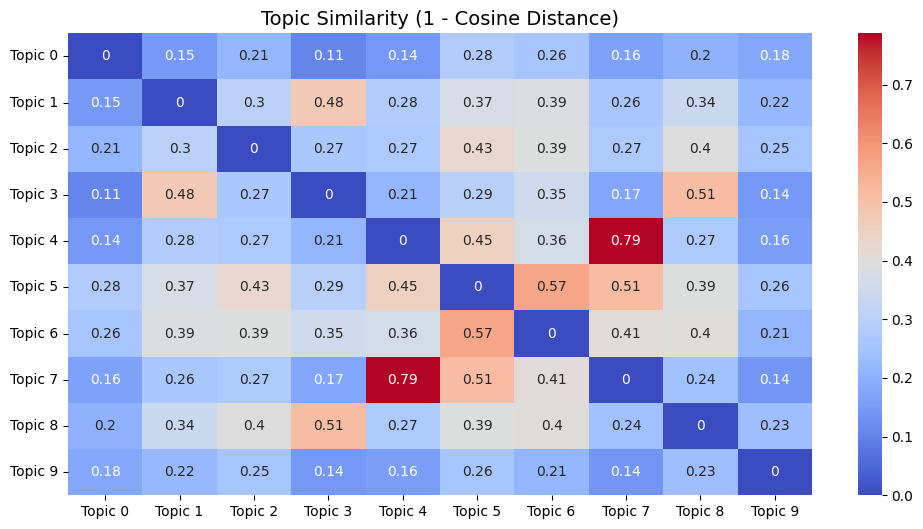

In [ ]:
similarity_matrix = np.zeros((10,10))

for i in range(10): #10 are num_topics
  for j in range(10): #10 are num_topics
    if i!= j:
     similarity_matrix[i, j] = 1 - cosine(topic_vectors[i], topic_vectors[j])

plt.figure(figsize=(12,6))
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm',
            xticklabels=[f'Topic {i}' for i in range(10)],
            yticklabels=[f'Topic {i}' for i in range(10)])
plt.title('Topic Similarity (1 - Cosine Distance)', fontsize = 14)
plt.show()

1. Values close to 1 indicate very similar topics (red, orange and lightgrey)

2. Values close to 0 indicate not very similar topics(blue, lightblue)

# Extracting information about the mentioned organizations from the NON SPAM emails.

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

# set ham emails dataset
ham_emails = dataset[dataset['label'] == 0]['text']

ham_emails

,text
605,subject enron methanol meter follow note gave ...
2349,subject hpl nom january see attached file hpln...
3624,subject neon retreat ho ho ho around wonderful...
2030,subject indian spring deal book teco pvr reven...
2949,subject ehronline web address change message i...
...,...
1428,subject meter august allocation exception cono...
2849,subject fw crosstex energy driscoll ranch mete...
1518,subject put ft transport volume decreased cont...
404,subject following noms hpl take extra mmcf wee...


In [ ]:
def entities(email):
  to_return = {'ORG':[]}
  doc = nlp(email)
  for ent in doc.ents:
    if ent.label_ == 'ORG':
      to_return['ORG'].append((ent.text))
  return to_return

In [ ]:
organizations = ham_emails.apply(entities)
print(organizations)

605                                           {'ORG': []}
2349                                          {'ORG': []}
3624                            {'ORG': ['shop antique']}
2030                                          {'ORG': []}
2949                                          {'ORG': []}
                              ...                        
1428    {'ORG': ['aware daily', 'pat clynes corp enron...
2849    {'ORG': ['subject fw crosstex energy driscoll ...
1518                      {'ORG': ['chokshi corp enron']}
404                                     {'ORG': ['noms']}
1409                                          {'ORG': []}
Name: text, Length: 3531, dtype: object


In [ ]:
email = 'Google and Microsoft are working together on AI research.'

entities(email)

{'ORG': ['Google', 'Microsoft', 'AI']}

# Final Conclusion

This models (Logistic Regression and Complement Naive Bayes) can be detect and categorize all of the total spam emails.
Some spam emails (33 for LR and 7 for CNB) are classified as ham.

The models are considered to be quite efficient.

So which model to choose?

* If we want to reduce False Positive (FP) and have a more reliable system for the user : **Complement NB** is better.

* If we want to catch every single spam emails, with more False Positive cases: **Logistic Regression** is better.